**Importing Kaggle Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farmanshahab","key":"670dd841768f4fe39e4743daec8e2d4c"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv '/content/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
# download competition dataset
! kaggle competitions download -c deepfake-detection-challenge

100% 4.13G/4.13G [03:44<00:00, 22.8MB/s]
100% 4.13G/4.13G [03:44<00:00, 19.8MB/s]


In [ ]:
!mkdir deepfake_detection
!unzip /content/deepfake-detection-challenge.zip -d deepfake_detection

mkdir: cannot create directory ‘deepfake_detection’: File exists
Archive:  /content/deepfake-detection-challenge.zip
  inflating: deepfake_detection/sample_submission.csv  
  inflating: deepfake_detection/test_videos/aassnaulhq.mp4  
  inflating: deepfake_detection/test_videos/aayfryxljh.mp4  
  inflating: deepfake_detection/test_videos/acazlolrpz.mp4  
  inflating: deepfake_detection/test_videos/adohdulfwb.mp4  
  inflating: deepfake_detection/test_videos/ahjnxtiamx.mp4  
  inflating: deepfake_detection/test_videos/ajiyrjfyzp.mp4  
  inflating: deepfake_detection/test_videos/aktnlyqpah.mp4  
  inflating: deepfake_detection/test_videos/alrtntfxtd.mp4  
  inflating: deepfake_detection/test_videos/aomqqjipcp.mp4  
  inflating: deepfake_detection/test_videos/apedduehoy.mp4  
  inflating: deepfake_detection/test_videos/apvzjkvnwn.mp4  
  inflating: deepfake_detection/test_videos/aqrsylrzgi.mp4  
  inflating: deepfake_detection/test_videos/axfhbpkdlc.mp4  
  inflating: deepfake_detection/te

**Importing Libraries**

In [4]:
import os, re, time, tqdm, json, dlib
import PIL, cv2
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
from pylab import *
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, InputLayer
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

**Video Processing**

In below code, we will apply video processing to capture frames in videos and then making seperate images of realand fake, so that the necessary computation can be done efficiently.

In [5]:
# making additional directories
os.mkdir('/content/working')
os.mkdir('/content/working/dataset')
os.mkdir('/content/working/dataset/real')
os.mkdir('/content/working/dataset/fake')

In [6]:
drive_folder = '/content/drive/MyDrive/DFDC'

Video: /content/deepfake_detection/train_sample_videos/dvakowbgbt.mp4
Duration: 10.01 seconds
Frame Count: 300
Frame Rate: 29.97 frames per second
Resolution: 1920x1080



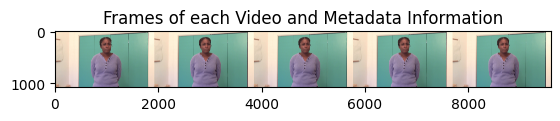


Video: /content/deepfake_detection/train_sample_videos/bdgipnyobr.mp4
Duration: 10.01 seconds
Frame Count: 300
Frame Rate: 29.97 frames per second
Resolution: 1920x1080



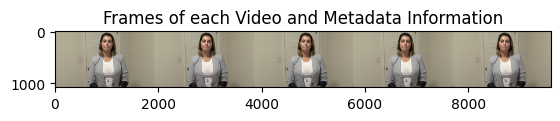


Video: /content/deepfake_detection/train_sample_videos/btohlidmru.mp4
Duration: 10.01 seconds
Frame Count: 300
Frame Rate: 29.97 frames per second
Resolution: 1920x1080



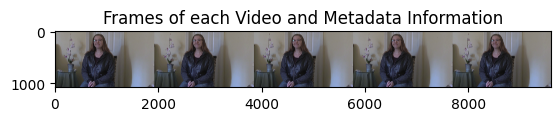


Video: /content/deepfake_detection/train_sample_videos/dulanfulol.mp4
Duration: 10.01 seconds
Frame Count: 300
Frame Rate: 29.97 frames per second
Resolution: 1920x1080



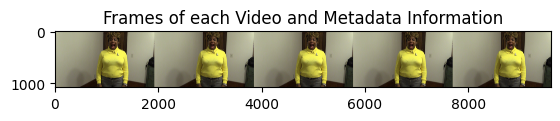


Video: /content/deepfake_detection/train_sample_videos/aevrfsexku.mp4
Duration: 10.01 seconds
Frame Count: 300
Frame Rate: 29.97 frames per second
Resolution: 1920x1080



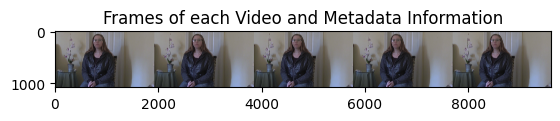

In [ ]:
def analyze_frames_and_metadata(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frame_count, fps, width, height = (
        int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        cap.get(cv2.CAP_PROP_FPS),
        int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    )
    cap.release()

    # Print metadata information in a concise format
    print(f"Video: {video_path}\nDuration: {frame_count / fps:.2f} seconds\nFrame Count: {frame_count}\nFrame Rate: {fps} frames per second\nResolution: {width}x{height}\n")

    # Analyze frames
    frame_interval = max(frame_count // num_frames, 1)
    frames_for_analysis = [cv2.VideoCapture(video_path).read()[1] for _ in range(0, frame_count, frame_interval)]
    analyze_frames_horizontal(frames_for_analysis)

def analyze_frames_horizontal(frames):
    concatenated_frame = cv2.hconcat(frames)
    plt.imshow(cv2.cvtColor(concatenated_frame, cv2.COLOR_BGR2RGB))
    plt.title("Frames of each Video and Metadata Information")
    plt.show()
    print()

# Replace 'your_video_path.mp4' with the actual path to your video file
train_frame_folder = '/content/deepfake_detection/train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)

# Analyze frames and print metadata for the first 5 videos
list_of_train_data = [os.path.join(train_frame_folder, f) for f in os.listdir(train_frame_folder) if f.endswith('.mp4')][:5]
for video_path in list_of_train_data:
    analyze_frames_and_metadata(video_path)


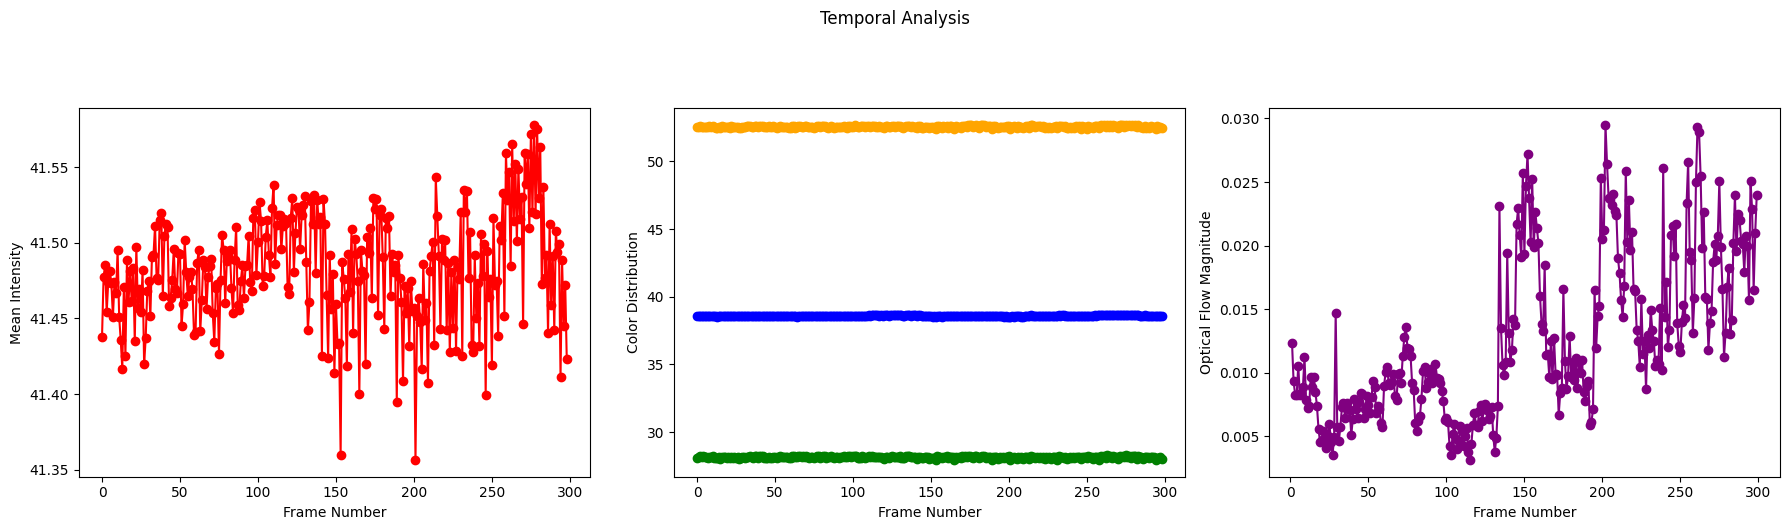

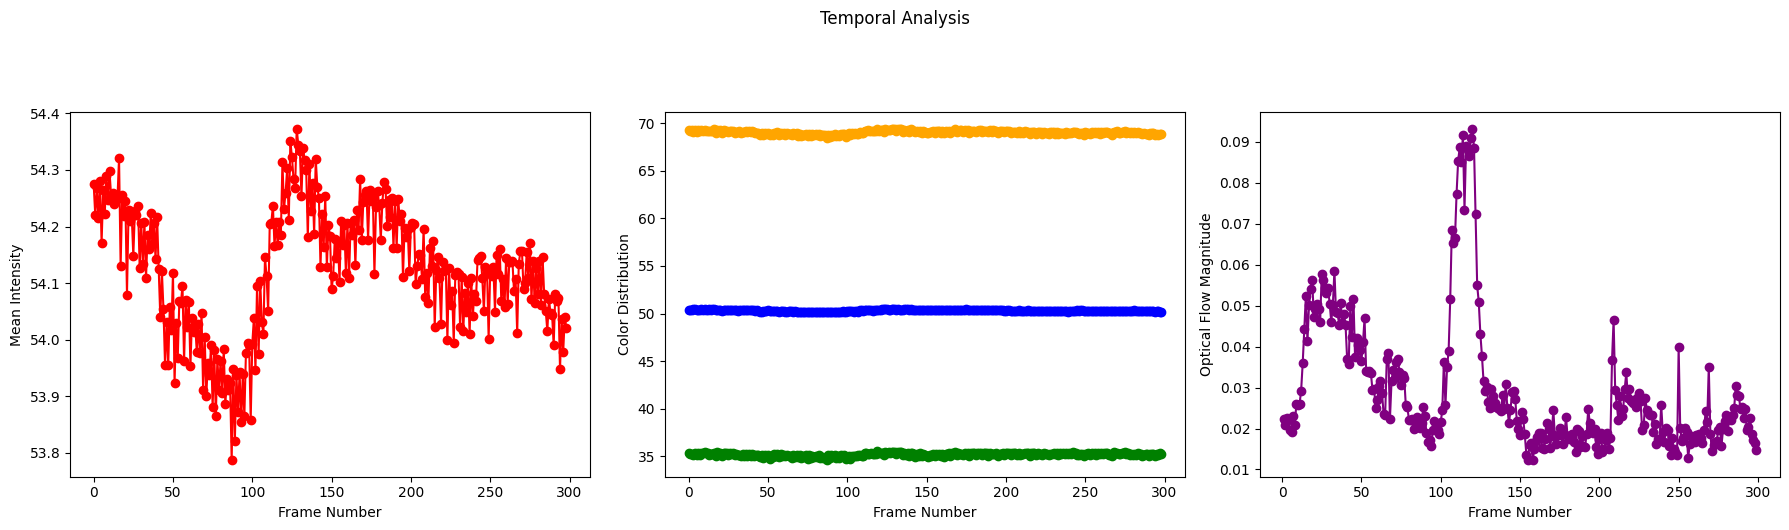

In [ ]:
def temporal_analysis(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Lists to store temporal features
    mean_intensities = []
    color_distributions = []
    optical_flow_magnitudes = []

    # Initialize the previous frame
    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        return

    # Calculate features for each frame
    for frame_num in range(1, frame_count):  # Start from the second frame
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale for intensity analysis
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate mean intensity of the frame (normalize to 0-300)
        mean_intensities.append(np.mean(gray_frame) * (300 / 255))

        # Calculate color distribution of the frame (normalize to 0-300)
        color_distribution = frame.reshape((-1, 3)).mean(axis=0)
        color_distributions.append(color_distribution * (300 / 255))

        # Calculate optical flow magnitude (normalize to 0-300)
        prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, gray_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude = np.sqrt(flow[..., 0] ** 2 + flow[..., 1] ** 2).mean()
        optical_flow_magnitudes.append(magnitude * (300 / 255))

        # Update the previous frame
        prev_frame = frame

    cap.release()

    # Convert color_distributions to NumPy array
    color_distributions = np.array(color_distributions)

    # Plot the temporal changes in features using subplots in a single row
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot mean intensity
    axs[0].plot(range(len(mean_intensities)), mean_intensities, label='Mean Intensity', linestyle='-', marker='o', color='red')
    axs[0].set_ylabel("Mean Intensity")
    axs[0].set_xlabel("Frame Number")

    # Plot color distribution
    axs[1].plot(range(len(color_distributions)), color_distributions[:, 0], label='Color (Blue)', linestyle='-', marker='o', color='green')
    axs[1].plot(range(len(color_distributions)), color_distributions[:, 1], label='Color (Green)', linestyle='-', marker='o', color='blue')
    axs[1].plot(range(len(color_distributions)), color_distributions[:, 2], label='Color (Red)', linestyle='-', marker='o', color='orange')
    axs[1].set_ylabel("Color Distribution")
    axs[1].set_xlabel("Frame Number")

    # Plot optical flow magnitude
    axs[2].plot(range(1, len(optical_flow_magnitudes) + 1), optical_flow_magnitudes, label='Optical Flow Magnitude', linestyle='-', marker='o', color='purple')
    axs[2].set_ylabel("Optical Flow Magnitude")
    axs[2].set_xlabel("Frame Number")

    # Set common title
    fig.suptitle("Temporal Analysis", y=1.05)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Replace 'your_video_path.mp4' with the actual path to your video file
train_frame_folder = '/content/deepfake_detection/train_sample_videos'
list_of_train_data = [os.path.join(train_frame_folder, f) for f in os.listdir(train_frame_folder) if f.endswith('.mp4')][:2]

for video_path in list_of_train_data:
    temporal_analysis(video_path)


In [ ]:
train_frame_folder = '/content/deepfake_detection/train_sample_videos'

with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)

list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()

for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)

    # Create folders for real and fake frames in the Google Drive folder
    real_folder = os.path.join(drive_folder, 'real')
    fake_folder = os.path.join(drive_folder, 'fake')

    os.makedirs(real_folder, exist_ok=True)
    os.makedirs(fake_folder, exist_ok=True)

    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate) + 1) * 1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]

                # Check if the file already exists before saving
                if data[vid]['label'] == 'REAL':
                    filename = os.path.join(real_folder, vid.split('.')[0]+'_'+str(count)+'.png')
                elif data[vid]['label'] == 'FAKE':
                    filename = os.path.join(fake_folder, vid.split('.')[0]+'_'+str(count)+'.png')

                if not os.path.exists(filename):
                    cv2.imwrite(filename, cv2.resize(crop_img, (224, 224)))
                count += 1

FileNotFoundError: ignored

**Data Augmentation**

Making a Training/Testing Data Generator Object

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     validation_split=0.2)

In [8]:
test_datagen = ImageDataGenerator(rescale=1/255.0)

**Making Training & Testing Datasets**

In [9]:
X = Y = 224
BATCH_SIZE = 128
seed = tf.random.set_seed(4200)

train_data = train_datagen.flow_from_directory(
                  directory='/content/drive/MyDrive/DFDC',
                  target_size=(X, Y),
                  color_mode="rgb",
                  batch_size=BATCH_SIZE,
                  class_mode="binary", subset="training",
                  seed=seed
                  )

test_data = train_datagen.flow_from_directory(
                  directory='/content/drive/MyDrive/DFDC',
                  target_size=(Y, Y),
                  color_mode="rgb",
                  batch_size=BATCH_SIZE,
                  class_mode="binary", subset="validation",
                  seed=seed
                  )

Found 2997 images belonging to 3 classes.
Found 748 images belonging to 3 classes.


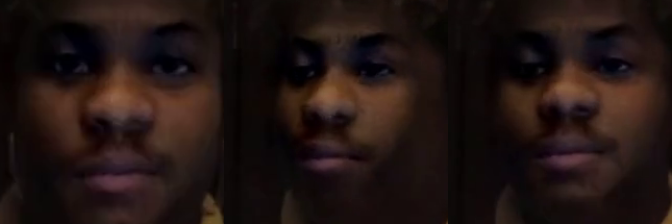

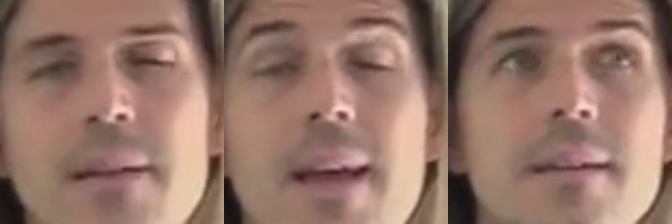

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os

# Function to display first three images from a directory
def display_images(directory_path):
    images = [cv2.imread(os.path.join(directory_path, filename)) for filename in os.listdir(directory_path)][:3]
    horizontally_concatenated = cv2.hconcat(images)
    cv2_imshow(horizontally_concatenated)

# Display images for the 'fake' directory
display_images('/content/drive/MyDrive/DFDC/fake')

# Display images for the 'real' directory
display_images('/content/drive/MyDrive/DFDC/real')



In [10]:
values_counter = Counter(train_data.classes)
sorted(values_counter.items())

[(1, 2389), (2, 608)]

In [11]:
train_data.classes

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [12]:
labels = dict()
for label_name,label_num in train_data.class_indices.items():
  labels[label_num] = label_name

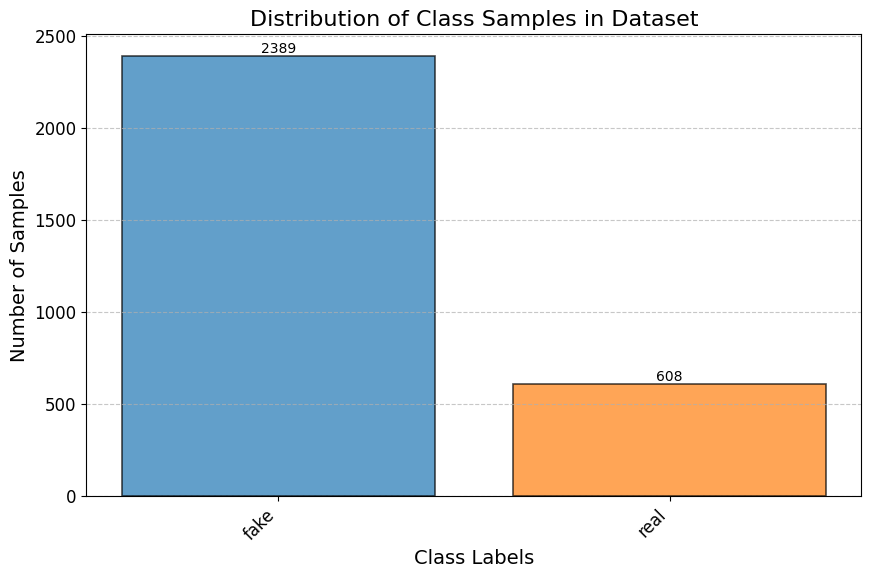

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Distribution of Class Samples in Dataset', fontsize=16)

# Using different styles for the bars
plt.bar(train_data.class_indices.keys(), values_counter.values(), color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black', linewidth=1.2)

# Adding data labels
for i, v in enumerate(values_counter.values()):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

# Customizing axes and ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Applying InceptionResNet V2**

In [13]:
from tensorflow.keras.applications import InceptionResNetV2
'''# Load InceptionResNetV2 model
base_model = keras.applications.InceptionResNetV2(include_top=False,
                             weights='imagenet',
                             input_shape=(X, Y, 3))

for layer in base_model.layers:
  layer.trainable = False'''

'''
x = GlobalAveragePooling2D()(base_model.output)
# x = Dense(1024, activation='relu')(x)
sequence_length = 10
x = tf.keras.layers.Reshape((sequence_length, -1))(x)

# adding an LSTM layer
lstm_units = 256  # Number of LSTM units
lstm_layer = LSTM(lstm_units)(x)

# add a Dense layer for final classification
output_layer = Dense(1, activation='sigmoid')(lstm_layer)
'''
# Load InceptionResNetV2 model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(X, Y, 3))

for layer in base_model.layers[:-20]:
    layer.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [14]:
'''model = Sequential()

model.add(base_model)

# model.add(keras.layers.TimeDistributed(Flatten()))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
# model.add((LSTM(units=2048)))

model.add(Dense(256, activation='relu'))

model.add((Dense(1, activation='sigmoid'))) '''
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

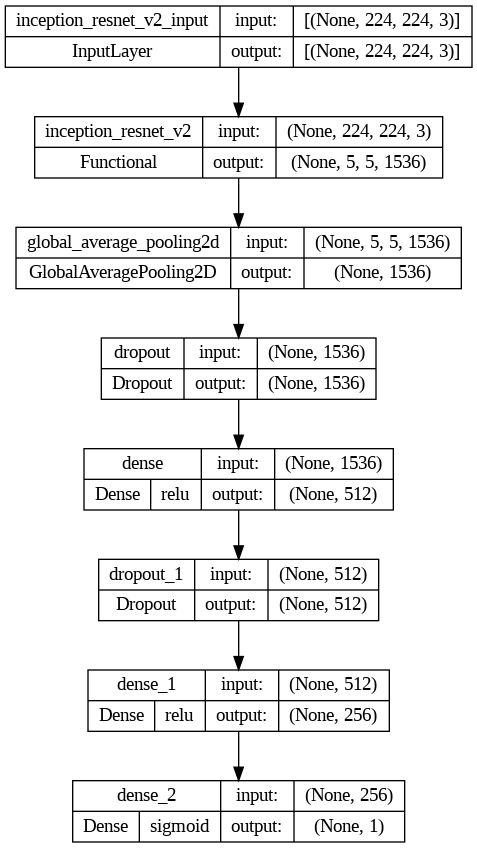

In [ ]:
plot_model(model, "model_resnet_lstm.png", show_layer_names=True,
           show_layer_activations=True, show_shapes=True)

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
train_labels = train_data.classes
train_labels

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [18]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.001,
                               patience=5,
                               verbose=1)

checkpoint = ModelCheckpoint("/content/drive/MyDrive/DFDC/cnn-lstm",
                             monitor='val_accuracy', save_best_only=True)

redue_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5)

EPOCHS = 50
BATCH_SIZE = BATCH_SIZE
history = model.fit((train_data),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, checkpoint, redue_lr],
                    validation_data=test_data,
                    verbose=1)

Epoch 1/50


KeyboardInterrupt: ignored

**Loss/Accuracy of InceptionResNet V2**

In [ ]:
def plot_training_history(history):
  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']
  epochs = range(1, len(training_accuracy) + 1)

  fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
  ax1.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
  ax1.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
  ax1.set_title('Training and Validation Accuracy (InceptionResNet V2 CNN)')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax2.plot(epochs, training_loss, 'bo-', label='Training Loss')
  ax2.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
  ax2.set_title('Training and Validation Loss (InceptionResNet V2 CNN)')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend()
  plt.tight_layout()
  plt.show()

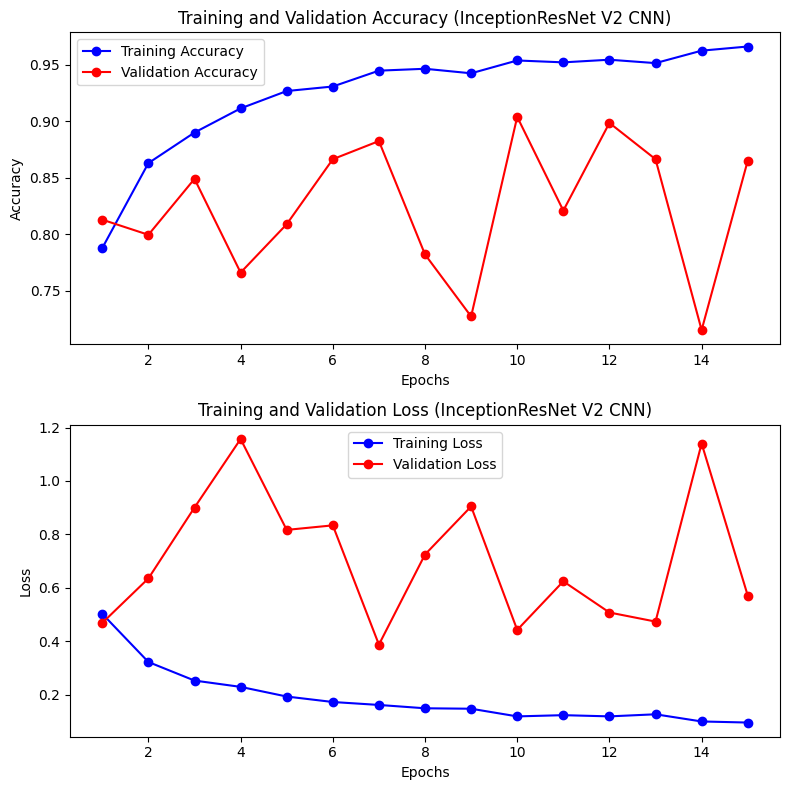

In [ ]:
plot_training_history(history)

**Evaluation and Testing:**

After training the model, it's important to evaluate its performance on a separate test set.

In [ ]:
# Load the trained model from the checkpoint file
trained_model = keras.models.load_model("/content/drive/MyDrive/DFDC/cnn-lstm")

# Evaluate the model on the test set
test_results = trained_model.evaluate(test_videos)

# Extract metrics
test_loss, test_accuracy = test_results[0], test_results[1]
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Make predictions on the test set
predictions = trained_model.predict(test_videos)

# Convert predictions to binary (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Obtain true labels
true_labels = test_videos.classes

# Calculate precision, recall, and confusion matrix
from sklearn.metrics import precision_score, recall_score, confusion_matrix

precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
conf_matrix = confusion_matrix(true_labels, binary_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


6/6 [==============================] - 19s 2s/step - loss: 0.3483 - accuracy: 0.9037
Test Loss: 0.3483
Test Accuracy: 90.37%
6/6 [==============================] - 18s 2s/step
Precision: 0.2199
Recall: 0.2053
Confusion Matrix:
[[487 110]
 [120  31]]


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Real', 'Fake']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()
